<a href="https://colab.research.google.com/github/TIRTHA1609045/AlzDisProject/blob/master/EfficientNetSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.9.1
!pip install tqdm
!pip install tensorflow_addons

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.9/dist-packages/tensorflow-2.11.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.11.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score

import tensorflow
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from tensorflow.keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import StratifiedKFold, KFold
import tensorflow_addons
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Nadam
import pathlib
from tqdm import tqdm

In [5]:
tensorflow.__version__

'2.9.1'

In [6]:
# Create a working directory

default_dir = "/content/drive/MyDrive/Dataset/AlzheimersDisease/AlzheimersDataset/"
root_dir = "/content/drive/MyDrive/Dataset/AlzheimersDisease/"
test_dir = default_dir + "test/"
train_dir = default_dir + "train/"
work_dir = root_dir + "AlzDisDS/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['ModerateDemented', 'MildDemented', 'NonDemented', 'VeryMildDemented']


In [47]:
WORK_DIR = '/content/drive/MyDrive/Dataset/AlzheimersDisease/AlzDisDS/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 208
IMAGE_SIZE = [208, 208]
DIM = (IMG_SIZE, IMG_SIZE)

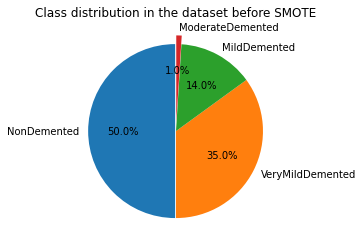

In [48]:
# Visualization of Working Directory before SMOTE

import os
import matplotlib.pyplot as plt

class_count = []
for class_name in CLASSES:
    class_path = os.path.join(WORK_DIR, class_name)
    class_count.append(len(os.listdir(class_path)))

plt.pie(class_count, labels=CLASSES, autopct='%1.1f%%', explode=(0.01, 0, 0, 0.1), startangle = 90)
plt.title('Class distribution in the dataset before SMOTE')
plt.show()


In [49]:
# Image Augmentation

work_dr = IDG(rescale = 1./255, brightness_range=[0.8, 1.2], zoom_range=[.99, 1.01], data_format="channels_last", fill_mode="constant", horizontal_flip=True, vertical_flip=False)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=True)

Found 6400 images belonging to 4 classes.


In [50]:
train_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

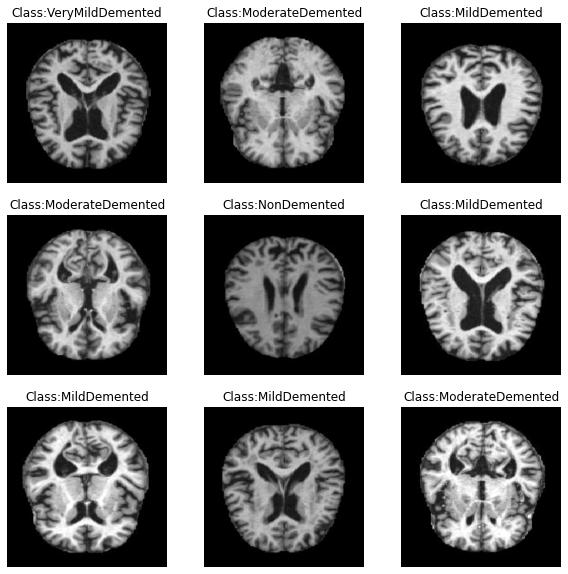

In [51]:
# Visualization of images

def show_images(generator,y_pred=None):
    # get image labels
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))                                 
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [52]:
# Load Data and Dataset Labelling

X, Y = train_data_gen.next()
print(X.shape, Y.shape)

(6400, 208, 208, 3) (6400, 4)


In [53]:
# SMOTE

sm = SMOTE(random_state=42)
X, Y = sm.fit_resample(X.reshape(-1, IMG_SIZE * IMG_SIZE * 3), Y)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(X.shape, Y.shape)

(12800, 208, 208, 3) (12800, 4)


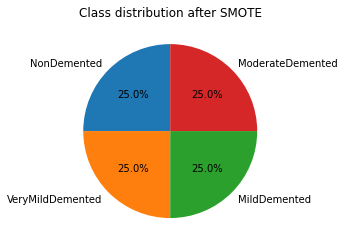

In [54]:
# Visualization in Pie Chart after SMOTE

from collections import Counter

class_names = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']  
class_labels = [class_names[np.argmax(y)] for y in Y]
class_counts = Counter(class_labels)
labels, counts = zip(*class_counts.items())

plt.pie(counts, labels=labels, autopct='%1.1f%%', explode=(0, 0, 0, 0), startangle = 90)
plt.title('Class distribution after SMOTE')
plt.show()

In [55]:
#Splitting data ke data train, data test, and data validation sets

train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size = 0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state=42)

In [56]:
# EfficientNetB0
base_model = EfficientNetB0(input_shape = (IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)

for layer in base_model.layers[:-3]:
    layer.trainable=False

model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation = 'softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 flatten_5 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_16 (Bat  (None, 62720)            250880    
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 32)                2007072   
                                                                 
 batch_normalization_17 (Bat  (None, 32)               128       
 chNormalization)                                     

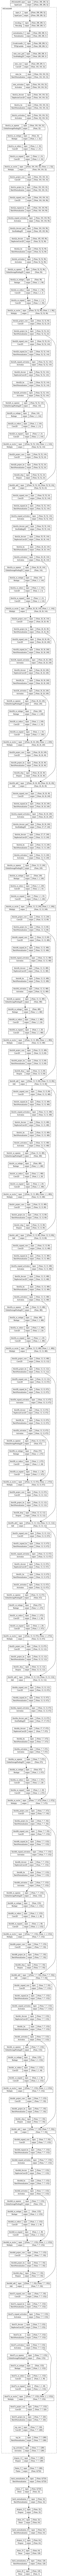

In [57]:
# Visualization of efficientnetb0 diagram

plot_model(model, to_file='/content/drive/MyDrive/Dataset/AlzheimersDisease/efficientnet-b0.png', show_shapes=True, show_layer_names=True,
          rankdir='TB', expand_nested=True)


In [58]:
METRICS = [tensorflow.keras.metrics.CategoricalAccuracy(name='acc'),
           tensorflow.keras.metrics.AUC(name='auc'), 
           tensorflow_addons.metrics.F1Score(num_classes=4)]

In [59]:
opt = Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [60]:
callbacks = [ 
       ModelCheckpoint('/content/drive/MyDrive/Dataset/AlzheimersDisease/effb0smote.hdf5', monitor='val_acc', 
                       save_best_only=False, mode='max', verbose=1),
       ##LambdaCallback(on_epoch_end=lambda epoch, logs: model.save('/content/drive/MyDrive/Dataset/AlzheimersDisease/effb0smote.pkl')),
       ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=10, verbose=1, mode='max')
       ##EarlyStopping(monitor='val_loss', mode='max', patience=10, verbose=1)
    ]

In [61]:
#vgg19_model.load_weights('/content/drive/MyDrive/Dataset/SkinCancerMalignantvsBenignMain/SCMalvsBenMainVgg19/mainvgg19.h5')

history = model.fit(train_data, train_labels, 
                          epochs=50,
                          batch_size = 8,
                          #steps_per_epoch = 2637/32,
                          validation_data=(val_data, val_labels), 
                          callbacks=callbacks)

Epoch 1/50
1293/1296 [============================>.] - ETA: 0s - loss: 1.5353 - acc: 0.2554 - auc: 0.5005 - f1_score: 0.2553
Epoch 1: saving model to /content/drive/MyDrive/Dataset/AlzheimersDisease/effb0smote.hdf5
1296/1296 [==============================] - 31s 19ms/step - loss: 1.5350 - acc: 0.2553 - auc: 0.5007 - f1_score: 0.2552 - val_loss: 1.3940 - val_acc: 0.2847 - val_auc: 0.5133 - val_f1_score: 0.1108 - lr: 0.0010
Epoch 2/50
1295/1296 [============================>.] - ETA: 0s - loss: 1.4406 - acc: 0.2493 - auc: 0.4948 - f1_score: 0.2491
Epoch 2: saving model to /content/drive/MyDrive/Dataset/AlzheimersDisease/effb0smote.hdf5
1296/1296 [==============================] - 23s 18ms/step - loss: 1.4406 - acc: 0.2492 - auc: 0.4948 - f1_score: 0.2490 - val_loss: 1.3982 - val_acc: 0.2517 - val_auc: 0.4762 - val_f1_score: 0.1006 - lr: 0.0010
Epoch 3/50
1294/1296 [============================>.] - ETA: 0s - loss: 1.4162 - acc: 0.2463 - auc: 0.4965 - f1_score: 0.2459
Epoch 3: saving mo

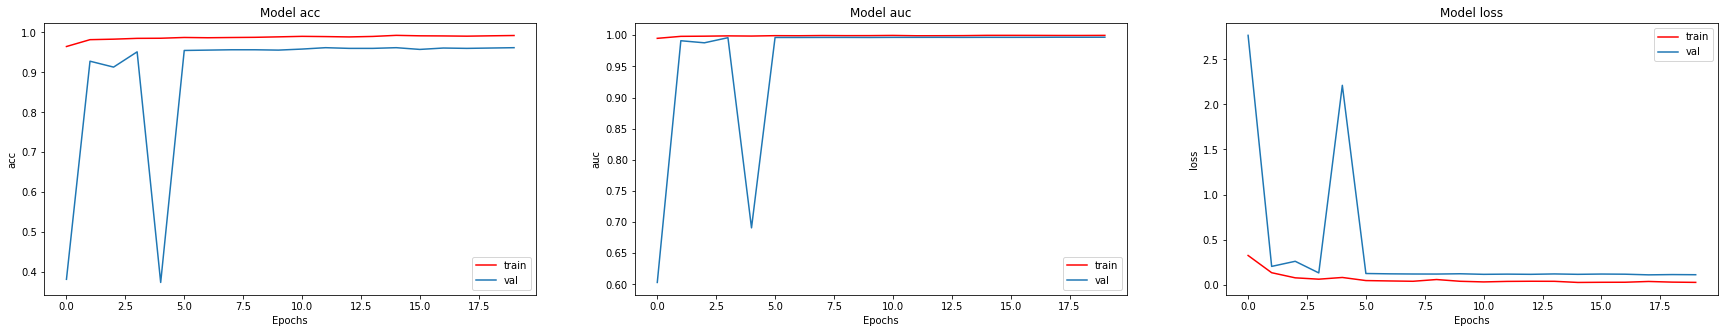

In [ ]:

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric],color="r")
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
test_scores = model.evaluate(test_data, test_labels)

print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 1s 23ms/step - loss: 0.0968 - acc: 0.9664 - auc: 0.9973 - f1_score: 0.9665
Test Accuracy: 96.64%


In [ ]:
pred_labels = model.predict(test_data)

40/40 [==============================] - 3s 25ms/step


In [ ]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.98      0.99       329
VeryMildDemented       1.00      1.00      1.00       311
    MildDemented       0.96      0.92      0.94       334
ModerateDemented       0.92      0.96      0.94       306

       micro avg       0.97      0.97      0.97      1280
       macro avg       0.97      0.97      0.97      1280
    weighted avg       0.97      0.97      0.97      1280
     samples avg       0.97      0.97      0.97      1280



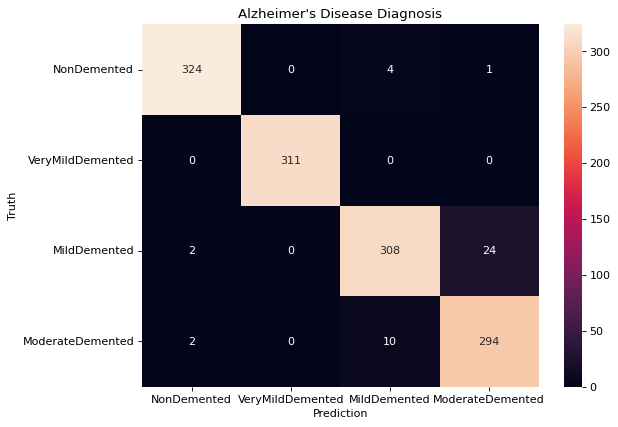

In [ ]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("MCC: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

In [ ]:
# image please check and try to implement these libraries. 

# 1. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# 2. https://www.tensorflow.org/tutorials/images/data_augmentation
# 3. Think about customizing own model
#     3.1. Change size from 96 x 96 to 224 x 224
#     # 3.2. I think loss curves are not working. 
        # 3.2.1. feed one batch to the network and see the value of loss. 
        # compare the loss from raw loss with trained epoch loss... 
        # if loss doesn't change then not working/ 
        # learn Git. 